# Text Mining (6) - Text Representation, Topic Modelling, Prediction
## Machine Learning Lectures by the ESA Data Analytics Team for Operations (DATO)
#### [José Martínez Heras](https://www.linkedin.com/in/josemartinezheras/)

## Resouces
This notebook is best followed when watched along to its corresponding [text mining ESA News **video**](https://dlmultimedia.esa.int/download/public/videos/2048/04/012/4804_012_AR_EN.mp4)

The tutorial about Text Mining, tf-idf, topic modelling and prediction can be found in the [2018-MachineLearning-Lectures-ESA **GitHub**](https://github.com/jmartinezheras/2018-MachineLearning-Lectures-ESA)


## Goal of today's project
Learn to represent text and make predictions based on text data

In particular, we will look at the ESA News in http://www.esa.int/Our_Activities/Space_News


## Import Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,4.5) # Make the default figures a bit bigger

import numpy as np
import pandas as pd
import random

#Let's make this notebook reproducible 
np.random.seed(42)
random.seed(42)

import seaborn as sb
import string
from pandas import DataFrame
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords
import nltk
from sklearn.decomposition import NMF
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, pairwise
import pydotplus
from sklearn.externals.six import StringIO  
from IPython.display import Image  

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jamheras\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jamheras\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data
I built a web scrapper to automatically get data from http://www.esa.int/Our_Activities/Space_News and stored it in the file 'esa_news_all.hdf'

In [3]:
store = pd.HDFStore('data/esa_news_all.hdf')
news = store['esa_news'] 
store.close()
news = news.dropna()
news.head()

,date,title,url,text,rating,votes,views,n_images,n_videos
id,,,,,,,,,
1,2018-04-13,Storm hunter in position,http://www.esa.int/Our_Activities/Human_Spacef...,"\nThe Atmosphere-Space Interactions Monitor, a...",4.9,62.0,2585.0,2.0,1.0
2,2018-04-12,Mars impact crater or supervolcano?,http://www.esa.int/Our_Activities/Space_Scienc...,\nThese images from ESAs Mars Express show a c...,4.8,173.0,7991.0,6.0,0.0
3,2018-04-12,Top tomatoes thanks to Mars missions,http://www.esa.int/Our_Activities/Space_Engine...,"\nNext time you eat a tomato or sweet pepper, ...",4.9,108.0,8718.0,3.0,0.0
4,2018-04-11,Mars Express v2.0,http://www.esa.int/Our_Activities/Operations/M...,"\nEvery so often, your smartphone or tablet re...",4.9,196.0,7370.0,2.0,2.0
5,2018-04-10,Swarm tracks elusive ocean magnetism,http://www.esa.int/Our_Activities/Observing_th...,\nThe magnetic field is arguably one of the mo...,5.0,93.0,6991.0,1.0,2.0


## Data Preparation

### Let's put together the title and the text

In [4]:
texts = news['title'] + ' ' + news['text']
texts.head()

id
1    Storm hunter in position \nThe Atmosphere-Spac...
2    Mars impact crater or supervolcano? \nThese im...
3    Top tomatoes thanks to Mars missions \nNext ti...
4    Mars Express v2.0 \nEvery so often, your smart...
5    Swarm tracks elusive ocean magnetism \nThe mag...
dtype: object

### Put everything to lowercase, remove new lines, punctuations, etc.

In [5]:
texts = texts.dropna()
texts = texts.str.lower()

replacements = {'\\n':' ', 'ñ':'n', 'u2028':'', '\. ':' ', ':':'', ';':'', ':':'', '-\t':'', '- ':' ', '\t':'', '/':' ', '(':'',
                ',':' ', '#':'', '\\':'', '\'':'', '"':'', '&\d+':'', 'cis-lunar':'cislunar', 'cis lunar':'cislunar', ' \d ':' ',
                '>|<':'', '\d+':'', '~':'', 'et al':'', 'in flight':'in-flight', 'on-board':'onboard', 'on board':'onboard',
                'on-ground':'onground', 'on ground':'onground', 'fact sheet':'', '-':'', 'e\.g':'', 'etc\.':'', '\?':'', '  +':' ',
                '[\0\200-\377\2028]':'', '“':'', '”':'', '’s':'', '\\+':'', '\\-':'', '\\@':'', 's’':'', 'baueresa':'', 'markus':'',
                'tel':'', 'int':'', 'email':'', 'bauer':'', 'let':'', 'astrium':'', 'could':''}

for value in replacements:
    texts = texts.str.replace(value, replacements[value])

news['text'] = texts
news['text'].head()

id
1    storm hunter in position the atmospherespace e...
2    mars impact crater or supervolcano these image...
3    top tomatoes thanks to mars missions next time...
4    mars express v. every so often your smartphone...
5    swarm tracks elusive ocean magnetism the magne...
Name: text, dtype: object

### Stem data
Stemming is a good idea as it reduces the number of different words. Similar variations share the same representation

In [6]:
stemmer = WordNetLemmatizer()
print('child    -> ' + stemmer.lemmatize('child') )
print('children -> ' + stemmer.lemmatize('children') )

child    -> child
children -> child


### Stop Words
Some words can make document appear to be more similar than they are as they share many similar words like: "a", "the", "one". Likely, the nltk library comes with a list of stop words for almost every language. We will discard the words in our news article that are included in these stop words.

In [7]:
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### Convert a list of texts to a stemmed lists of texts with stop words removed

In [8]:
def stem_texts(text_list):
    stop_words = stopwords.words('english')
    stop_words.extend([])
    stemmer = WordNetLemmatizer()
    stemmed_list = []
    
    for line in text_list:
        stemmed_line = ''
        for word in line.split(' '):
            if word in stop_words:
                continue
            stemmed = stemmer.lemmatize(word)
            stemmed_line += stemmed + ' '
        stemmed_list.append(stemmed_line.strip())
    return stemmed_list

In [9]:
original_text = 'today we are talking about text mining on esa news'
stemmed_text = stem_texts([original_text])[0]
print('original: ' + original_text)
print('stemmed:  ' + stemmed_text)

original: today we are talking about text mining on esa news
stemmed:  today talking text mining esa news


In [10]:
text_list = texts.tolist()
stemmed_list = stem_texts(text_list)


## Bag of Words representation with tf-idf

In [11]:
vectorizer = TfidfVectorizer(stop_words=stop_words, use_idf=True, ngram_range=(1, 1), min_df=0.01)
tfidf = vectorizer.fit_transform(stemmed_list)
tfidf.shape

(1161, 3372)

### Keywords that tf-idf uses
display the first 20 ...

In [12]:
print(vectorizer.get_feature_names()[:20])

['ability', 'able', 'aboard', 'absolute', 'absorb', 'abundance', 'ac', 'academy', 'accelerating', 'acceleration', 'accepted', 'access', 'accessible', 'accompanied', 'according', 'account', 'accuracy', 'accurate', 'accuray', 'achieve']


### This is how the tf-idf matrix looks like

In [13]:
tfidf_df = pd.DataFrame(tfidf.todense(), columns=vectorizer.get_feature_names(), index = news.index)
tfidf_df.head()

,ability,able,aboard,absolute,absorb,abundance,ac,academy,accelerating,acceleration,...,xray,xrays,year,yesterday,yet,yield,yielding,young,zero,zone
id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.00000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.136407,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,0.0,0.00000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.016303,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,0.0,0.00000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.067625,0.000000,0.0,0.0,0.0
4,0.0,0.02423,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.094481,0.035776,0.031570,0.000000,0.000000,0.0,0.0,0.0
5,0.0,0.00000,0.0,0.0,0.0656,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.017895,0.000000,0.041856,0.000000,0.064808,0.0,0.0,0.0


## Automatic Topic Extraction
The assumption here is that every news article deals with a set of topics. Let's find automatically which are the topics each article talks about.

In [14]:
n_topics = 20
n_top_words = 4

def print_top_words(model, feature_names, n_top_words):
    topics_dict = dict()
    for topic_idx, topic in enumerate(model.components_):
        print("topic %d: " % topic_idx, end='')
        topics = " ".join([feature_names[i] + "," for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(topics)
        topics_dict['topic_' + str(topic_idx)] = topics
    print()
    return topics_dict

nmf = NMF(n_components=n_topics, init='nndsvd', random_state=42)
nmf.fit(tfidf)
topics = nmf.transform(tfidf)
print("Reconstruction error: " + str(nmf.reconstruction_err_))
print("\nTopics in NMF model:")
tfidf_feature_names = vectorizer.get_feature_names()
topics_dict = print_top_words(nmf, tfidf_feature_names, n_top_words)


columns_name = [topics_dict['topic_' + str(i)] for i in range(n_topics)]
topics_df = pd.DataFrame(topics, columns = columns_name)
topics_df.index = news.index


Reconstruction error: 29.218723860146675

Topics in NMF model:
topic 0: space, laser, salite, technology,
topic 1: comet, rosetta, philae, lander,
topic 2: astronaut, station, space, andreas,
topic 3: galileo, salites, navigation, launch,
topic 4: mar, schiaparelli, exomars, orbiter,
topic 5: ariane, kg, va, launch,
topic 6: crater, mar, image, region,
topic 7: ice, cryosat, glacier, arctic,
topic 8: business, company, startup, technology,
topic 9: sentinel, copernicus, sentinela, salite,
topic 10: esa, space, european, state,
topic 11: atv, station, cargo, docking,
topic 12: swarm, magnetic, field, earth,
topic 13: experiment, concordia, cell, research,
topic 14: star, galaxy, herschel, black,
topic 15: vega, ixv, reentry, vehicle,
topic 16: asteroid, object, neo, ssa,
topic 17: gaia, star, milky, billion,
topic 18: ocean, water, smos, carbon,
topic 19: team, control, mission, esoc,



### This is how each article looks like

In [15]:
titles = news['title'].str.replace('\\r\\n','').tolist()
dates = news['date']
titles = [(x[:40] + '..' if len(x) > 32 else x) for x in titles]
labels2 = [(str(d.year) + '-' + str(d.month) + '-' + str(d.day) + ' ' + str(t)) for (t,d) in zip(titles, dates)]
#labels2 = [(str(t) ) for t in titles]

topics_df2 = topics_df.copy()
topics_df2.index = labels2

topics_df2.head()

,"space, laser, salite, technology,","comet, rosetta, philae, lander,","astronaut, station, space, andreas,","galileo, salites, navigation, launch,","mar, schiaparelli, exomars, orbiter,","ariane, kg, va, launch,","crater, mar, image, region,","ice, cryosat, glacier, arctic,","business, company, startup, technology,","sentinel, copernicus, sentinela, salite,","esa, space, european, state,","atv, station, cargo, docking,","swarm, magnetic, field, earth,","experiment, concordia, cell, research,","star, galaxy, herschel, black,","vega, ixv, reentry, vehicle,","asteroid, object, neo, ssa,","gaia, star, milky, billion,","ocean, water, smos, carbon,","team, control, mission, esoc,"
2018-4-13 Storm hunter in position,0.016642,0.000000,0.040922,0.0,0.002776,0.0,0.006163,0.000000,0.017013,0.009773,0.010575,0.038243,0.000526,0.012093,0.033818,0.0,0.009576,0.000000,0.035290,0.070798
2018-4-12 Mars impact crater or supervolcano?..,0.000000,0.000000,0.000000,0.0,0.027627,0.0,0.214632,0.002090,0.001253,0.000000,0.000000,0.000000,0.003225,0.000000,0.006781,0.0,0.014739,0.000856,0.000000,0.000000
2018-4-12 Top tomatoes thanks to Mars missions..,0.000000,0.000000,0.000000,0.0,0.013504,0.0,0.010994,0.000000,0.071041,0.000000,0.000255,0.000000,0.000000,0.139197,0.000000,0.0,0.000000,0.000000,0.055799,0.001133
2018-4-11 Mars Express v2.0,0.015365,0.014939,0.002044,0.0,0.094432,0.0,0.030973,0.002807,0.016780,0.000000,0.000000,0.000000,0.006534,0.016222,0.002868,0.0,0.000000,0.016185,0.002681,0.113405
2018-4-10 Swarm tracks elusive ocean magnetism..,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.421518,0.000000,0.000000,0.0,0.000000,0.000000,0.027811,0.000000


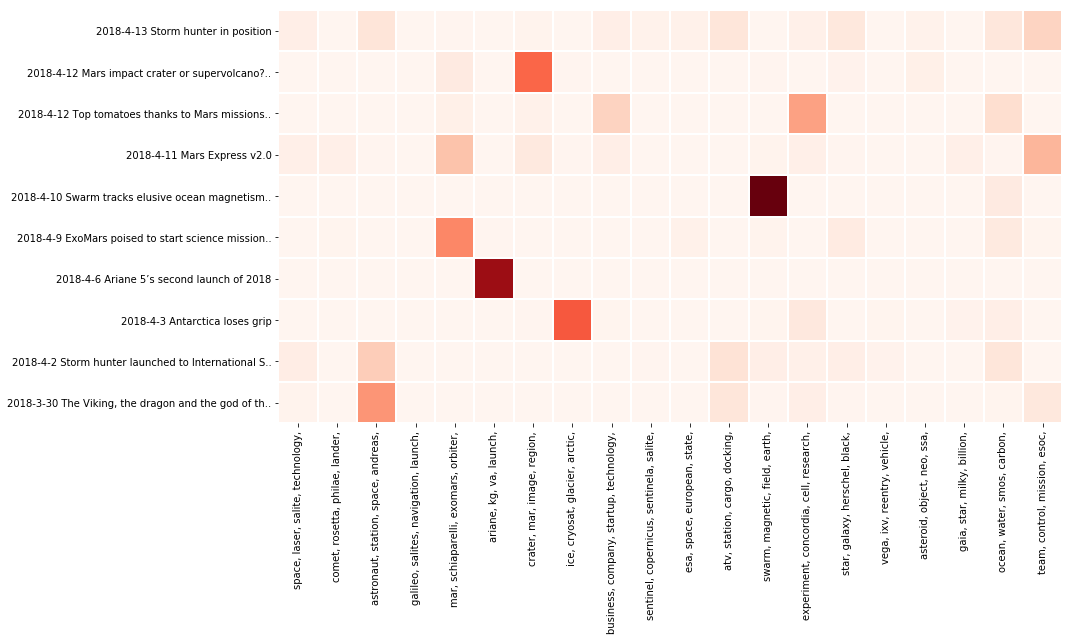

In [16]:
plt.figure(figsize=(15,9))
sb_plot = sb.heatmap(topics_df2[0:10], linewidths=1, cbar=False, cmap='Reds')
plt.tight_layout() #show plot with tight layout
plt.savefig('topics1.png', dpi=300)
#plt.savefig('topics1.pdf', dpi=300)

### Making use of similarity
Let's compute the pairwise similarity of each article to each other article and compute the average distance for every article
* Low average distances correspond to most common topic combinations
* High average distances correspond to most unusual topic combinations

In [17]:
th_date = '2017-01-01'
topics_df_bydate = topics_df.copy()
topics_df_bydate.index = news['date']
selection = topics_df_bydate.index >= pd.to_datetime(th_date)
recent = topics_df_bydate.loc[selection]

dist = pairwise.cosine_similarity(recent)
mean_dist = dist.mean(axis=1)
most_common = np.argsort(mean_dist)
most_different = most_common[::-1]

print('Most Common after ' + th_date)
for i in range(10):
    pos = most_common[i]
    row = news[selection].iloc[pos]
    print(str(i+1) + ': '+ str(round(mean_dist[pos],2)) + ', '+ str(row['date']) + ' ' + row['title'])
print()
print('Most Unusual after ' + th_date)
for i in range(10):
    pos = most_different[i]
    row = news[selection].iloc[pos]
    print(str(i+1) + ': '+ str(round(mean_dist[pos],2)) + ', '+ str(row['date']) + ' ' + row['title'])

Most Common after 2017-01-01
1: 0.06, 2017-10-26 00:00:00 Rosetta finds comet plume powered from below
2: 0.07, 2017-06-21 00:00:00 ESA marks #Asteroid Day
3: 0.07, 2017-10-23 00:00:00 Galileo in place for launch: then there were four
4: 0.07, 2017-10-02 00:00:00 Galileo pair arrives in French Guiana
5: 0.07, 2018-04-06 00:00:00 Ariane 5’s second launch of 2018
6: 0.07, 2017-01-10 00:00:00 Asteroid sleuths go back to the future
7: 0.07, 2017-02-14 00:00:00 Ariane 5’s first launch this year
8: 0.07, 2017-05-05 00:00:00 Ariane 5’s second liftoff this year
9: 0.07, 2017-11-08 00:00:00 Vega launches Earth observation satellite for Morocco
10: 0.07, 2017-12-08 00:00:00 Galileo satellites atop rocket for next Tuesday’s flight

Most Unusual after 2017-01-01
1: 0.33, 2017-09-26 00:00:00 Helicopter test for Jupiter icy moons radar
2: 0.33, 2018-03-20 00:00:00 Earth’s atmosphere: new results from the International Space Station
3: 0.32, 2018-04-13 00:00:00 Storm hunter in position
4: 0.32, 2017-

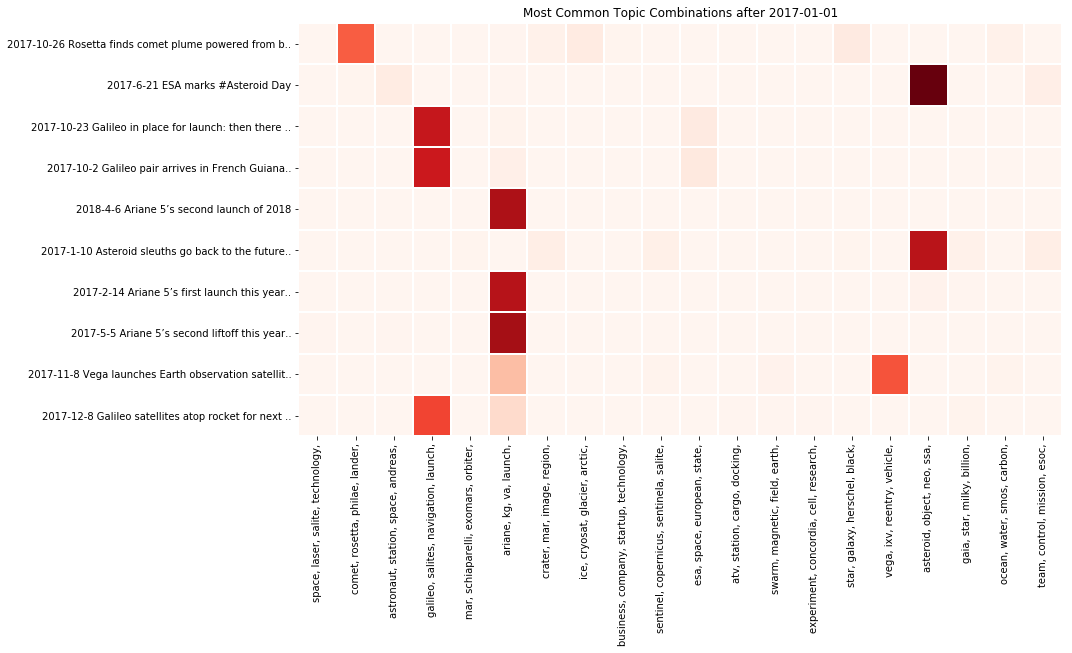

In [18]:
plt.figure(figsize=(15,9))
sb_plot = sb.heatmap(topics_df2.iloc[most_common[:10]], linewidths=1, cbar=False, cmap='Reds')
plt.tight_layout() #show plot with tight layout
plt.title('Most Common Topic Combinations after ' + th_date);

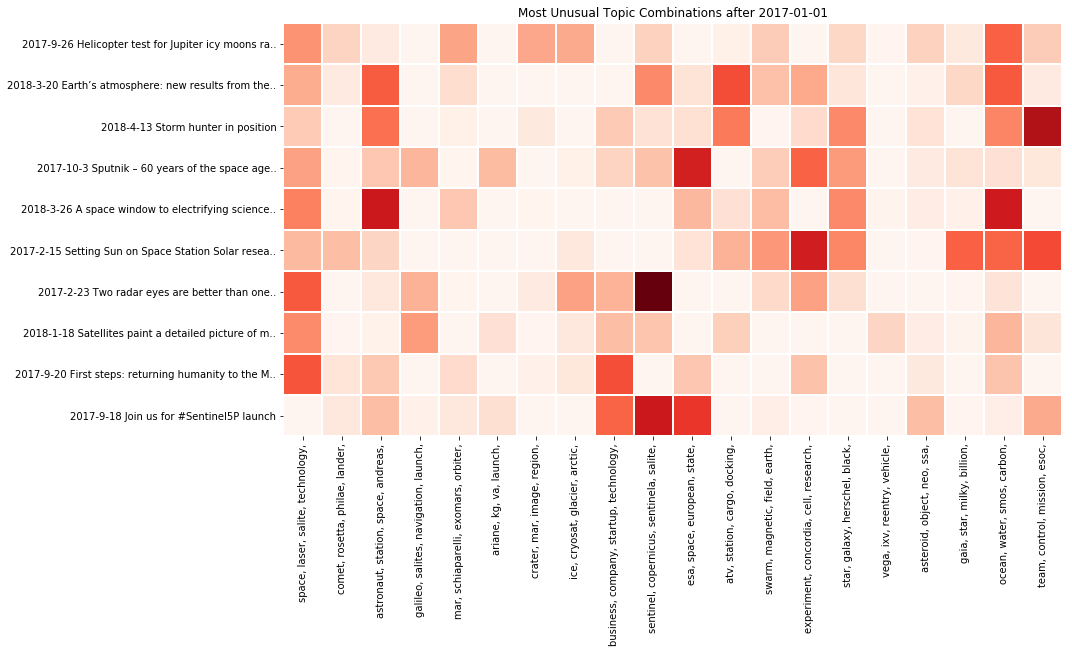

In [19]:
plt.figure(figsize=(15,9))
sb_plot = sb.heatmap(topics_df2.iloc[most_different[:10]], linewidths=1, cbar=False, cmap='Reds')
plt.tight_layout() #show plot with tight layout
plt.title('Most Unusual Topic Combinations after ' + th_date);

## Number of views of an article
Our task would be to predict the number of views an article will receive

Let's look at how they look like


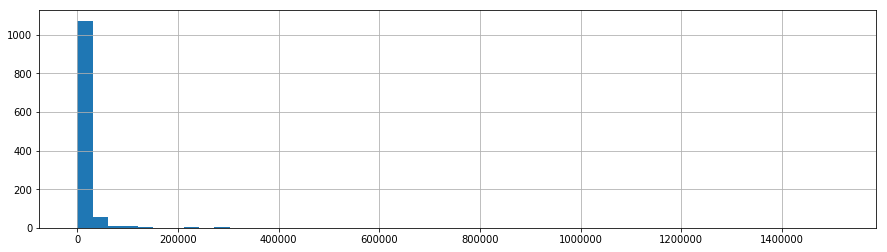

In [20]:
news['views'].hist(figsize=(15,4), bins=50);

Let's now plot an histogram for articles with less than 100,000 views

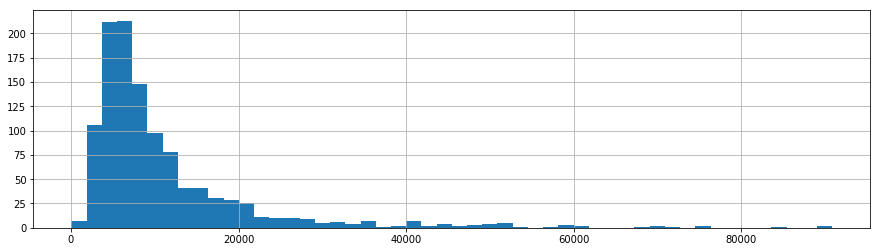

In [21]:
news['views'][news['views'] < 100000].hist(figsize=(15,4), bins=50);

Let's now plot an histogram for articles with less than 20,000 views

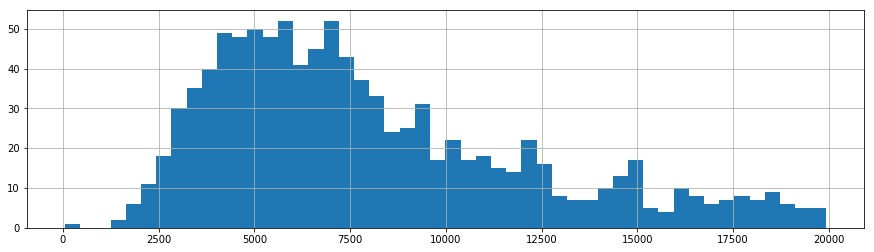

In [22]:
news['views'][news['views'] < 20000].hist(figsize=(15,4), bins=50);

### Change our prediction variable to binary for classification
It will be too difficult to predict the exact number of views an article will have, specially with such skewed distribution. So, we plan to transform the problem in a classification task.

The goal will be to predict if an article will receive a *High* or *Low* number of views.

* High is >= 10,000 views
* Low  is <=  6,300 views

Why 6,300? - you may ask ... because:
1. this allows as to have about the same number of instances for each class
2. it creates a gap between the 2 clases - making it easier for Machine Learning to find what make them really different

In [23]:
y = news['views'].copy()

th_high = 10000
th_low  =  6300
to_be_kept = ( (y <= th_low) | (y >= th_high))
y = y[to_be_kept]
y[y<=th_high] = 0
y[y>th_high] = 1

ratio_positive_class = np.sum(y == 1) / len(y)
print('ratio_positive_class: ' + str(round(ratio_positive_class, 2)))
print('size_positive_class: ' + str(np.sum(y==1)))
print('size_negative_class: ' + str(np.sum(y==0)))

ratio_positive_class: 0.5
size_positive_class: 420
size_negative_class: 417


## Machine Learning

Let's predict using tf-idf features first and topics features later

### Data Preparation for Machine Learning

In [24]:
selected_news = news[to_be_kept]
train_selection = ( (selected_news['date'] >= pd.to_datetime('2013-01-01')) & (selected_news['date'] < pd.to_datetime('2016-01-01')) )
test_selection  = ( (selected_news['date'] >= pd.to_datetime('2016-01-01')) & (selected_news['date'] < pd.to_datetime('2018-01-01')) )

y_train = y[train_selection]
y_test  = y[test_selection]

#### Same evaluation for the 2 approaches

In [25]:
def evaluate_model(y_true, y_pred):
    precision = precision_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)
    print('precision: {0:0.2f}, recall: {1:0.2f}, f1: {2:0.2f}'.format(precision, recall, f1))
    print('confusion matrix')
    print(matrix)
    
def get_importances(model, features, decimals=3):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    for f in range(min(10, len(indices))):
        feature = features[indices[f]]
        importance = importances[indices[f]]
        if importance < 0.001:
            break
        print(str(round(importance, decimals)) + " " + feature) 

### Machine Learning with tf-idf features
Our input will be the tf-idf matrix

In [26]:
tfidf_df.head()

,ability,able,aboard,absolute,absorb,abundance,ac,academy,accelerating,acceleration,...,xray,xrays,year,yesterday,yet,yield,yielding,young,zero,zone
id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.00000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.136407,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,0.0,0.00000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.016303,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,0.0,0.00000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.067625,0.000000,0.0,0.0,0.0
4,0.0,0.02423,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.094481,0.035776,0.031570,0.000000,0.000000,0.0,0.0,0.0
5,0.0,0.00000,0.0,0.0,0.0656,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.017895,0.000000,0.041856,0.000000,0.064808,0.0,0.0,0.0


In [27]:
X_tfidf = tfidf_df.copy()[to_be_kept]
X_tfidf_train = X_tfidf[train_selection]
X_tfidf_test  = X_tfidf[test_selection]


#### Train a Random Forest

In [28]:
rf_tfidf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=0.05, n_jobs=-1, random_state=42)
rf_tfidf.fit(X_tfidf_train, y_train)
pred_tfidf = rf_tfidf.predict(X_tfidf_test)

evaluate_model(y_true=y_test, y_pred=pred_tfidf)

precision: 0.64, recall: 0.73, f1: 0.69
confusion matrix
[[102  53]
 [ 35  96]]


In [29]:
get_importances(rf_tfidf, X_tfidf_train.columns)

0.037 solar
0.029 dust
0.026 material
0.025 application
0.021 planet
0.021 large
0.019 surface
0.019 km
0.017 astronaut
0.016 detected


#### Train a tree with tf-idf data and export it
Even if the tree performance is worse than the forest performance, it allows us to gain some insights

In [30]:
tree_tfidf = DecisionTreeClassifier(max_depth=5, min_samples_leaf=0.05, random_state=42)
tree_tfidf.fit(X_tfidf_train, y_train)
pred_tfidf = tree_tfidf.predict(X_tfidf_test)

evaluate_model(y_true=y_test, y_pred=pred_tfidf)

precision: 0.59, recall: 0.71, f1: 0.64
confusion matrix
[[90 65]
 [38 93]]


In [31]:
get_importances(tree_tfidf, X_tfidf_train.columns)

0.318 surface
0.159 galaxy
0.136 atmosphere
0.107 km
0.093 image
0.086 design
0.079 new
0.02 year
0.002 make


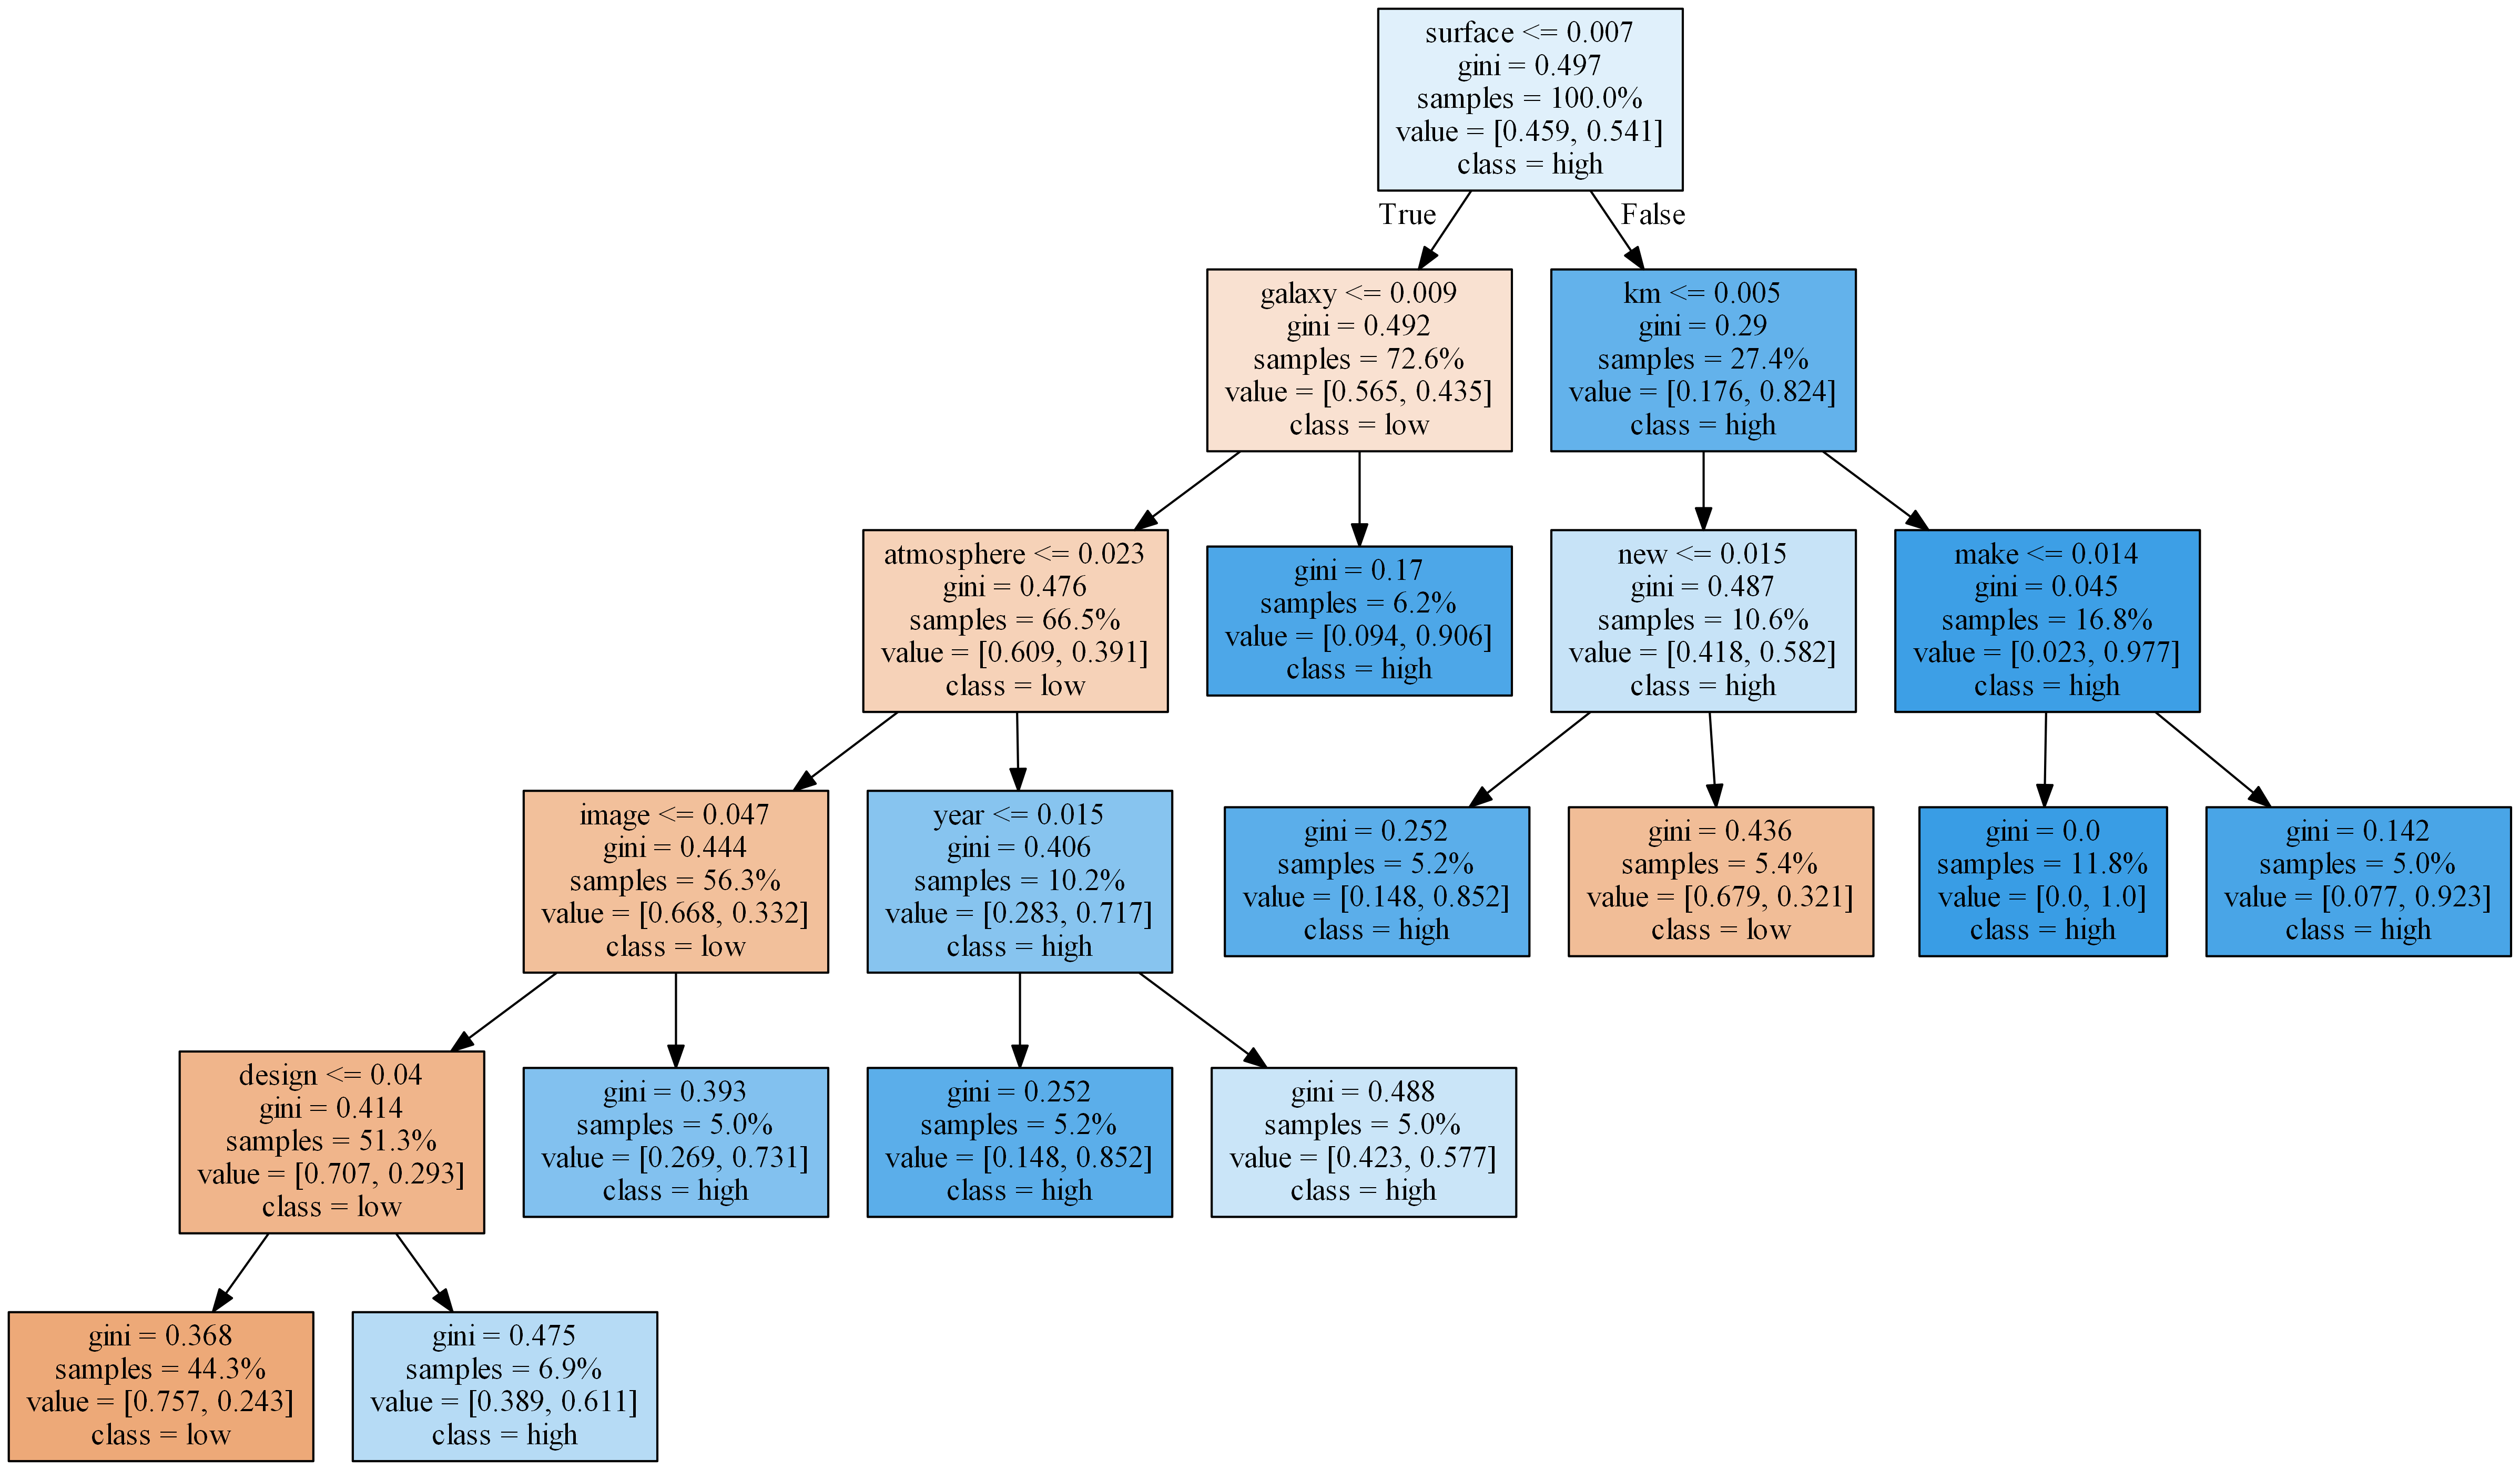

In [32]:
dot_data = StringIO()
export_graphviz(tree_tfidf, out_file=dot_data, feature_names=X_tfidf_train.columns.tolist(), filled=True, class_names=['low', 'high'], proportion = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create(prog=['dot', '-Gdpi=300'], format='png'))

#export_graphviz(tree, 'tree_tfidf.dot', feature_names=X.columns.tolist(), filled=True, class_names=['low', 'high'], proportion = True)


### Machine Learning with topics
Our input will be the topics matrix

In [33]:
topics_df.head()

,"space, laser, salite, technology,","comet, rosetta, philae, lander,","astronaut, station, space, andreas,","galileo, salites, navigation, launch,","mar, schiaparelli, exomars, orbiter,","ariane, kg, va, launch,","crater, mar, image, region,","ice, cryosat, glacier, arctic,","business, company, startup, technology,","sentinel, copernicus, sentinela, salite,","esa, space, european, state,","atv, station, cargo, docking,","swarm, magnetic, field, earth,","experiment, concordia, cell, research,","star, galaxy, herschel, black,","vega, ixv, reentry, vehicle,","asteroid, object, neo, ssa,","gaia, star, milky, billion,","ocean, water, smos, carbon,","team, control, mission, esoc,"
id,,,,,,,,,,,,,,,,,,,,
1,0.016642,0.000000,0.040922,0.0,0.002776,0.0,0.006163,0.000000,0.017013,0.009773,0.010575,0.038243,0.000526,0.012093,0.033818,0.0,0.009576,0.000000,0.035290,0.070798
2,0.000000,0.000000,0.000000,0.0,0.027627,0.0,0.214632,0.002090,0.001253,0.000000,0.000000,0.000000,0.003225,0.000000,0.006781,0.0,0.014739,0.000856,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.0,0.013504,0.0,0.010994,0.000000,0.071041,0.000000,0.000255,0.000000,0.000000,0.139197,0.000000,0.0,0.000000,0.000000,0.055799,0.001133
4,0.015365,0.014939,0.002044,0.0,0.094432,0.0,0.030973,0.002807,0.016780,0.000000,0.000000,0.000000,0.006534,0.016222,0.002868,0.0,0.000000,0.016185,0.002681,0.113405
5,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.421518,0.000000,0.000000,0.0,0.000000,0.000000,0.027811,0.000000


In [34]:
X_topics = topics_df.copy()[to_be_kept]
X_topics_train = X_topics[train_selection]
X_topics_test  = X_topics[test_selection]


#### Train a Random Forest

In [35]:
rf_topics = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=0.05, n_jobs=-1, random_state=42)
rf_topics.fit(X_topics_train, y_train)
pred_topics = rf_topics.predict(X_topics_test)

evaluate_model(y_true=y_test, y_pred=pred_topics)

precision: 0.66, recall: 0.71, f1: 0.69
confusion matrix
[[108  47]
 [ 38  93]]


In [36]:
get_importances(rf_topics, X_topics_train.columns)

0.235 business, company, startup, technology,
0.119 comet, rosetta, philae, lander,
0.119 crater, mar, image, region,
0.104 astronaut, station, space, andreas,
0.089 ariane, kg, va, launch,
0.064 star, galaxy, herschel, black,
0.046 sentinel, copernicus, sentinela, salite,
0.042 galileo, salites, navigation, launch,
0.039 esa, space, european, state,
0.028 mar, schiaparelli, exomars, orbiter,


#### Train a tree with topics data and export it
Even if the tree performance is worse than the forest performance, it allows us to gain some insights

In [37]:
tree_topics = DecisionTreeClassifier(max_depth=5, min_samples_leaf=0.05, random_state=42)
tree_topics.fit(X_topics_train, y_train)
pred_tree_topics = tree_topics.predict(X_topics_test)

evaluate_model(y_true=y_test, y_pred=pred_tree_topics)

precision: 0.62, recall: 0.72, f1: 0.66
confusion matrix
[[97 58]
 [37 94]]


In [38]:
get_importances(tree_topics, X_topics_train.columns)

0.438 business, company, startup, technology,
0.221 crater, mar, image, region,
0.163 comet, rosetta, philae, lander,
0.105 star, galaxy, herschel, black,
0.07 sentinel, copernicus, sentinela, salite,
0.003 space, laser, salite, technology,


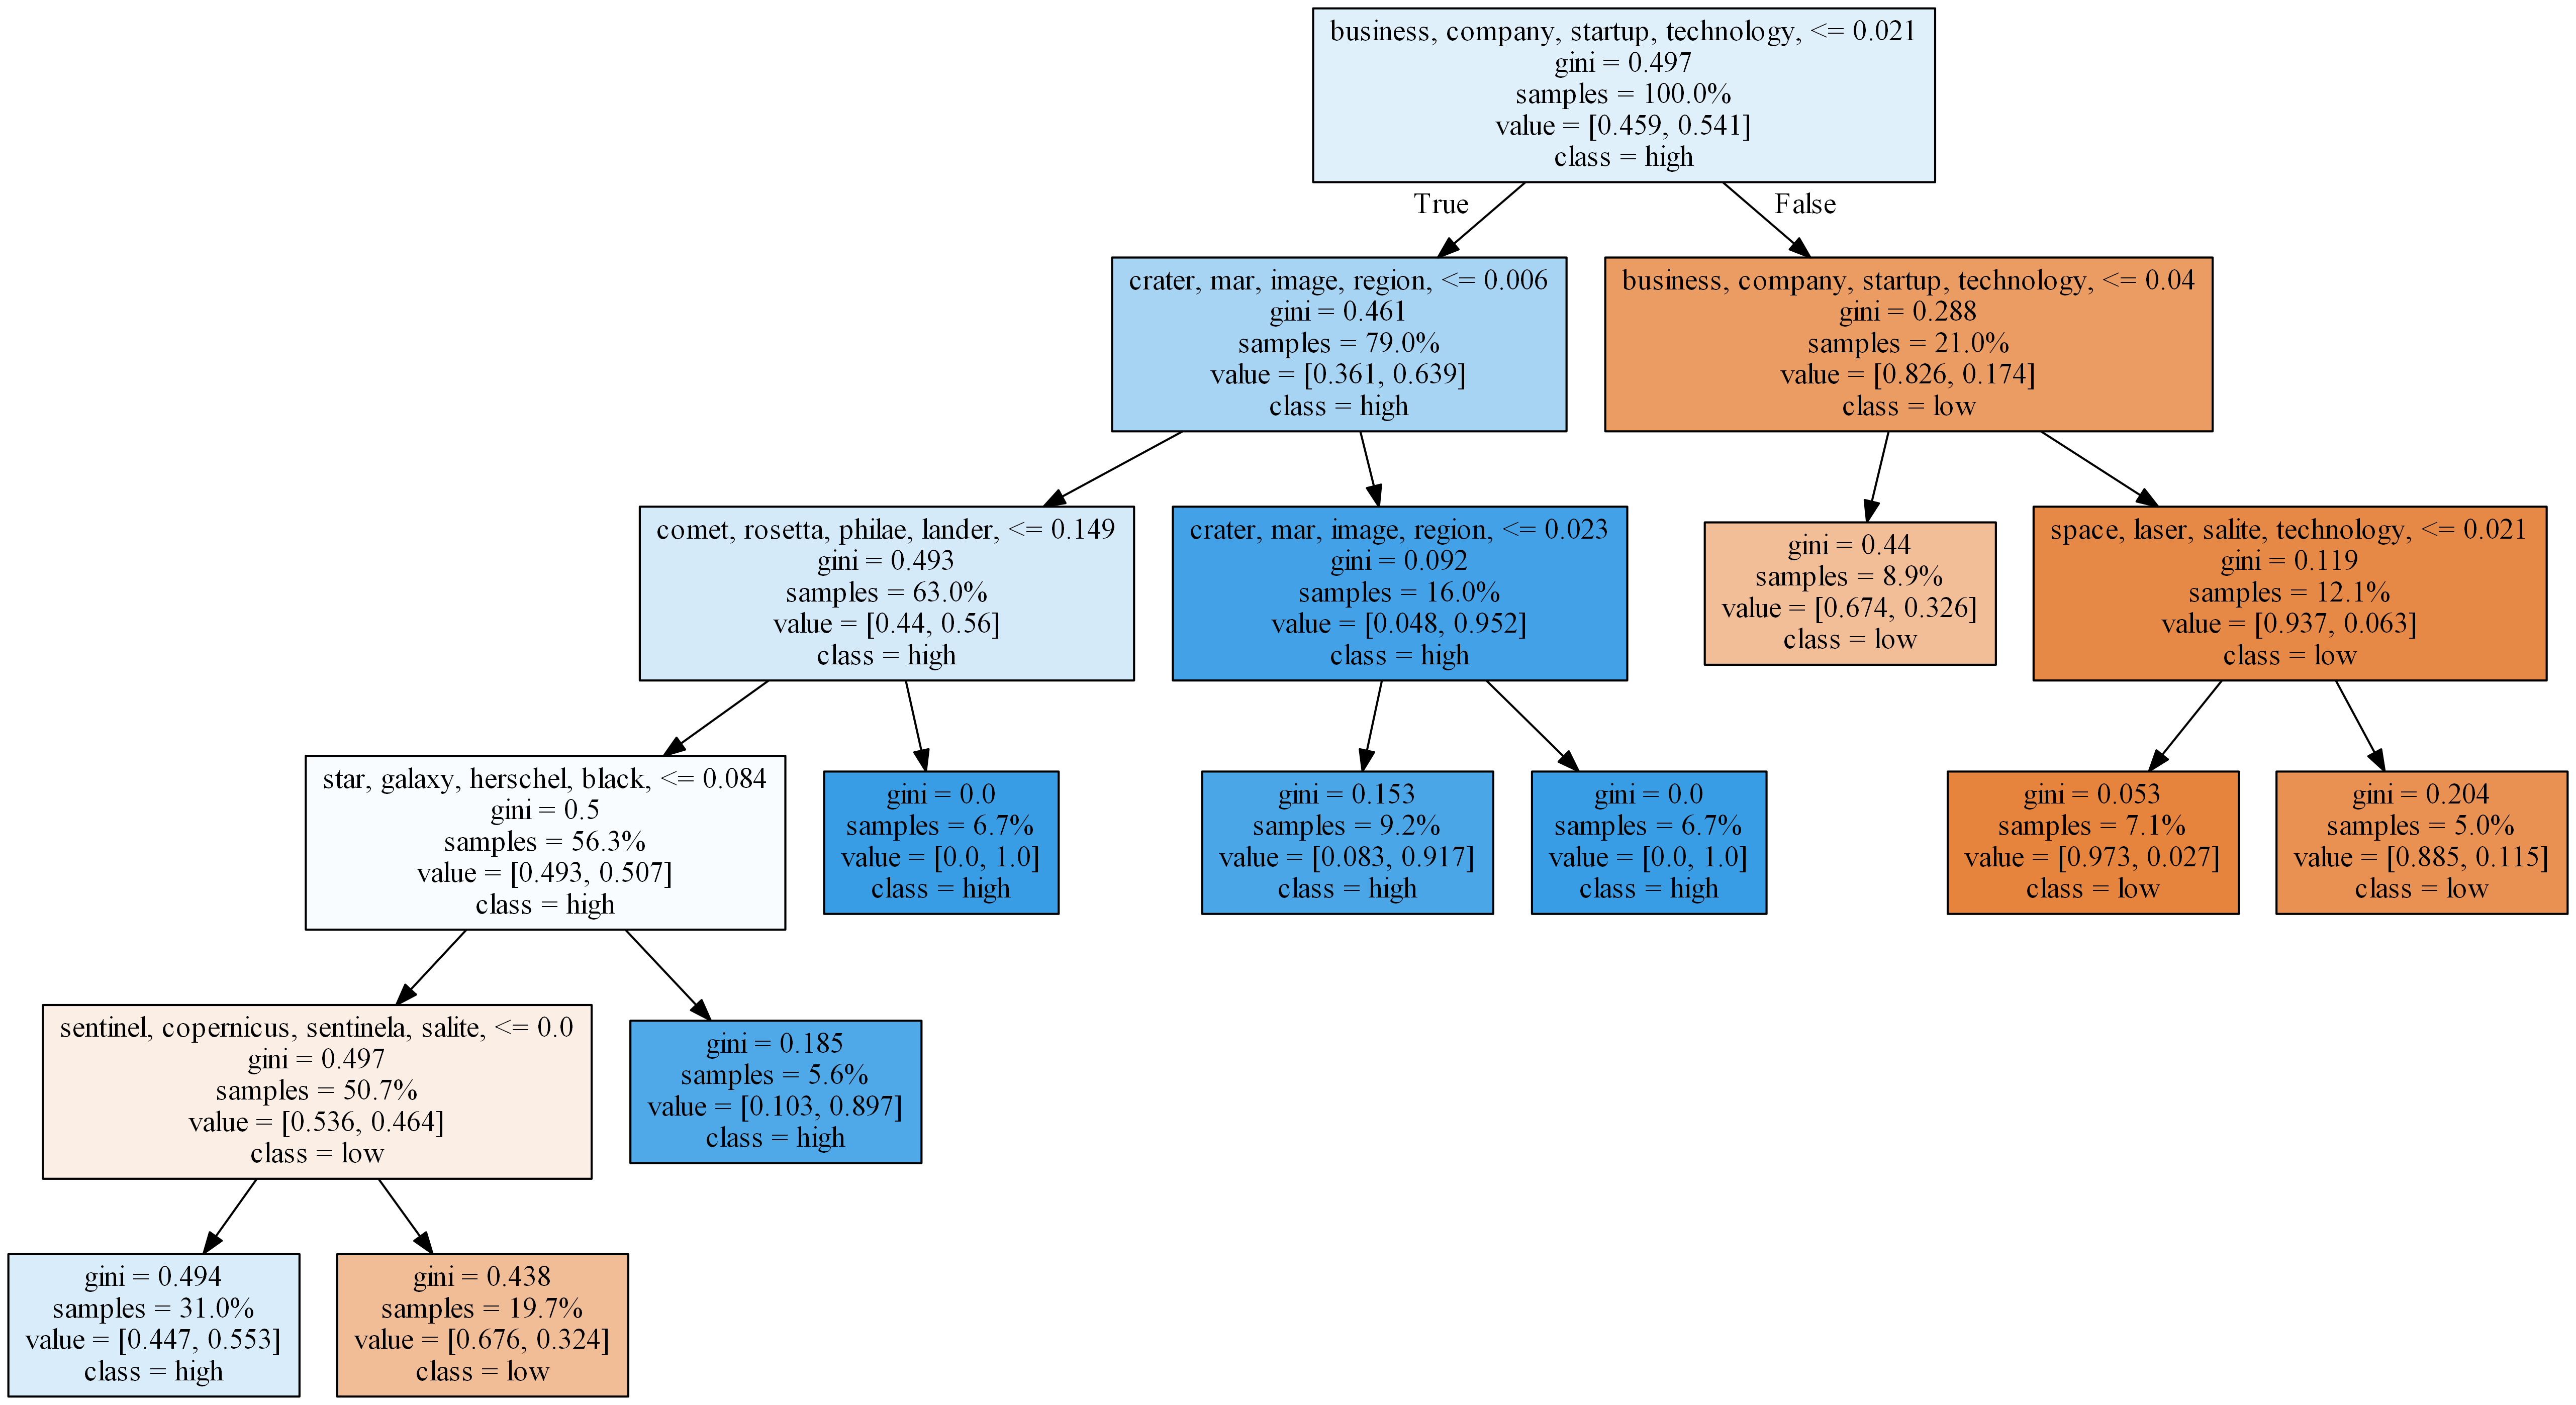

In [39]:
dot_data = StringIO()
export_graphviz(tree_topics, out_file=dot_data, feature_names=X_topics_train.columns.tolist(), filled=True, class_names=['low', 'high'], proportion = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create(prog=['dot', '-Gdpi=300'], format='png'))
#export_graphviz(tree, 'tree_topics.dot', feature_names=X.columns.tolist(), filled=True, class_names=['low', 'high'], proportion = True)

## Summary
* text preprocessing (lowercase, stop words, stemming)
* Topic extraction
* Find most similar / different topic combinations
* We learnt what makes an ESA News article to be popular (high number of views) by using Decision Tress with two approaches
    * tfidf terms
    * topics
* by checking the precision, recall and F1 measurements on test data (not used to build the model), we can see that this understanding has predicting power. 